# Introduction

This is my first attempt at working with NLP. Aiming to just get a reasonable submission in the easiest and fastest way possible.

## Contents

* Exploratory Data Analysis
* Data Cleansing
* Classifier and Predictions
* Evaluation and Submission

In [1]:
import os

## Importing required libraries and reading in our csv files

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re


from spellchecker import SpellChecker

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

In [9]:
# Printing the head of the DataFrame to get an overview of what it looks like
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


After printing the head of our training DataFrame we can see that this is a very simple data set. Containing the an ID, keyword, location, the tweet, and the classification. It is concerning that none of the visible rows contain values for keyword or location. Let's dig a little deeper.

In [10]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.0+ KB
None


Thankfully it seems like most of the data is populated. Although, the location column is missing over 30% of its values. This may become a problem if our model makes use of this field.

# Some basic EDA with comparisons between the Disaster/Non-Disaster tweets

0    0.57034
1    0.42966
Name: target, dtype: float64

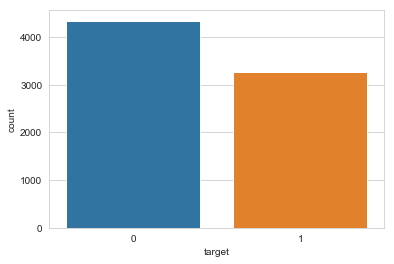

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='target', data=train_df)

train_df['target'].value_counts(normalize='True')

We have more non-disaster tweets than disaster tweets at a balance of 57% vs. 43%.

Next let's see if we can identify any obvious differences between the tweets in terms of length, characters, punctuation, etc.

The average word count for Non-Disaster tweets is 14.704744357438969
The average word count for Disaster tweets is 15.167532864567411


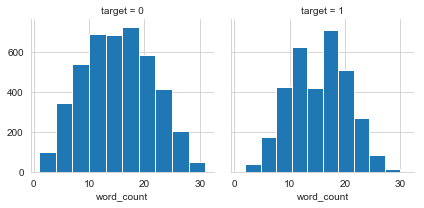

In [12]:
train_df['word_count']=train_df['text'].str.split().map(lambda x: len(x))
train_df['char_count']=train_df['text'].str.len()

grid = sns.FacetGrid(train_df, col='target')

grid.map(plt.hist, 'word_count')

print('The average word count for Non-Disaster tweets is {}'.format(train_df[train_df['target']==0]['word_count'].mean()))
print('The average word count for Disaster tweets is {}'.format(train_df[train_df['target']==1]['word_count'].mean()))

The average character count for Non-Disaster tweets is 95.70681713496084
The average character count for Disaster tweets is 108.11342097217977


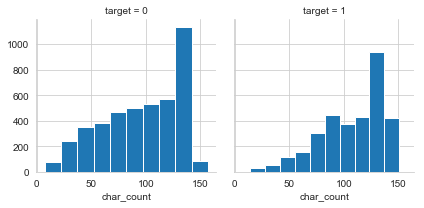

In [13]:
grid = sns.FacetGrid(train_df, col='target')

grid.map(plt.hist, 'char_count')

print('The average character count for Non-Disaster tweets is {}'.format(train_df[train_df['target']==0]['char_count'].mean()))
print('The average character count for Disaster tweets is {}'.format(train_df[train_df['target']==1]['char_count'].mean()))

Overall there isn't much to take away other than the following:

On average, the word count and character count of tweets relating to a disaster are longer than those not relating to a disaster. However, both types of tweets seem to be limited by Twitter's 144 character count maximum, shown by the bunching of data points at the high end. Perhaps a more recent data set that allows up to 280 characters (current Twitter limit) would widen the gap between these statistics.


# Cleaning the data

As shown in the previous analysis it is clear that we need to do some cleaning before we go anywhere near modelling. We will clean the data in the following ways:
* Removing Uneccesary Punctuation
* Removing HTML/URLs
* Spelling Correction

In [26]:
# Removing Punctuation
def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train_df['text']=train_df['text'].apply(lambda x : remove_punctuation(x))
test_df['text']=test_df['text'].apply(lambda x : remove_punctuation(x))


# Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train_df['text']=train_df['text'].apply(lambda x : remove_html(x))
test_df['text']=test_df['text'].apply(lambda x : remove_html(x))


# Removing URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train_df['text']=train_df['text'].apply(lambda x : remove_URL(x))
test_df['text']=test_df['text'].apply(lambda x : remove_URL(x))


# Correct Spelling
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)
#     print(len(misspelled_words))
    print(misspelled_words)
    return len(misspelled_words)

misspelled = 0
for text in train_df['text']:
    misspelled += correct_spellings(text)
print(misspelled)
# train_df['text']=train_df['text'].apply(lambda x : correct_spellings(x))
# test_df['text']=test_df['text'].apply(lambda x : correct_spellings(x))

set()
{'sask', 'ronge'}
set()
set()
set()
{'cafire', 'rockyfire', 'hwy'}
set()
set()
set()
set()
set()
{'fvck'}
{'tampabay'}
{'bago'}
set()
set()
set()
set()
set()
{'goooooooaaaaaal'}
set()
set()
set()
set()
{'looooool'}
set()
{'nyc'}
set()
{'cooool'}
set()
set()
{'bbcmtd', 'httptcolhyxeohy6c'}
{'httptcoyao1e0xngw', 'rt'}
{'httptco2nndbgwyei', 'newsnigeria', 'africanbaze'}
set()
{'httptcoqqsmshaj3n'}
{'mufc', 'phdsquares', 'epl'}
{'inec', 'httptco3imaomknna', 'abia'}
{'st', 'superintende', '\x89ûó', '\x89ûò', 'bridgetown', 'httptcowdueaj8q4j'}
{'d'}
{'httptcoroi2nsmejj', 'nsfw', 'httptco3tj8zjin21', 'httptcoyduixefipe', 'httptcolxtjc87kls'}
set()
{'ancop', 'cfc'}
{'southridgelife'}
{'httptcoo9qknbfofx'}
{'httptcotiyulif5c6'}
{'httptcovl5tbr3wbr'}
{'tracklist'}
{'httptcoroi2nsmejj', 'nsfw', 'httptco3tj8zjin21', 'httptcoyduixefipe', 'httptcolxtjc87kls'}
set()
{'httptcogwnrhmso8k'}
{'httptcoev1ahoucza'}
{'st', '\x89ûó', 'httptcovplr5hka2u', 'lanford', 'r', 'httptcosxhw2tnnlf'}
{'httptcopc

{'httptcohhtwayt4yo'}
{'httptcoggtmdquddo', 'ruor', 'usar2015', 'usar15'}
{'httptcokfyebhb3di', 'evanston'}
{'httpstco4zsxjgv7it', 'savebees', 'profithungry'}
{'laevantine'}
{'chemicalbabe'}
{'httptcoulupxyzjwv', 'v452'}
{'httptcoq9zixci8e6'}
{'lindenow', '315pm'}
{'dannyjohnjules', 'spencerfearon', 'christielinford'}
{'noooooooo', 'jeannamibian', 'd33munni'}
{'somethingyr'}
{'httptcoqamwojyahq'}
set()
{'2leezy', 'httpstcogrwdr4kuf3'}
set()
set()
set()
{'faved'}
{'httptcolci3pljx25', 'funnynews'}
{'httptcobmwmpoydig', 'ruebs', '4500feet'}
set()
set()
{'alexjacobsonpfs'}
{'httpstco4vwsl2gfp0'}
set()
{'httptconmhztb1ewm', 'thinkpink', 'magichairbump'}
set()
set()
set()
set()
{'sincerelyevelnn', 'punkblunts', 'idc'}
{'ruebs', '4500feet', 'httptcojxhazebnqk'}
{'szmnextdoor'}
{'n', 'httpstco3hoikdmocb'}
{'httptcogabd0cjmag'}
{'httptcoeeewo207mx', 'r'}
set()
{'gulfport', 'httptcocjuighbxyn'}
set()
{'otm'}
{'yoenis'}
{'httptcoio9ry1akon'}
{'esn', 'next\x89û', 'httptcof7a66diiyk'}
{'nowplaying

{'foxsportscom', 'ng2x5', 'mhtw4fnet', 'memebaiting'}
{'anthonys', 'smh'}
{'raidersreporter', '957thegame'}
{'creativitybalancelongevity', 'flatliners', 'httpstcowcfpznsn9u'}
{'httptcobtus5jejuy', 'httptcozrtfxluk6r'}
{'cluei', 'nicolekidman'}
{'yiayplan', 'amiibos'}
{'httptcozildpvknxp', 'httptco5ydb4s13pf', 'å£150', 'boylesports'}
{'petchary', 'reggaeboyz'}
{'cameronciletti', 'tigersjostun'}
set()
{'httptcosikkg0fphr', 'bwin', 'httptcojfyfzddlrn'}
{'hromadske', 'kasiadear33', 'sarniamakchris'}
{'brockton', 'c', 'regc', 'b', '12m', 'ppc'}
{'beconfident'}
{'fousey', 'fouseytube', 'zaynmalik', 'brbrs'}
{'2hours', 'httpstcowactt18gda', 'lmao'}
{'meekmill'}
{'sj', 'httptcodkrgs2awex', 'streetjamzdotnet', 'httpstcomr9kcgpiwm'}
set()
set()
{'msmigot', 'givingevidence'}
set()
set()
{'haaaaaa', 'sapphirescallop'}
set()
{'hlongwane', 'monwabisi', 'ashestoashes', 'r', 'ryt'}
{'mataas', 'kc', 'ratingbut', 'engineermatarai'}
{'elgeotaofeeq'}
{'gambia', 'nkea', 'justicemalala', 'nkeajresq'}
{'viab

{'n', 'httpstcouttanbigrx'}
{'httptcoresxavgpyj'}
{'httptco9hieifhsmc'}
{'httpstcolue3waegpi', 'you\x89û'}
{'httptcop9rymfjcux'}
{'writes4coffee', 'rrbc', 'tw4rw', 'rwa', 'httptcosto58qa94c', 'iartg'}
{'httptcogyh00mrkjm'}
{'httptcozonnqgsxyw'}
{'httpstco2fggzqn1v4', 'financialtimes'}
{'httptco0c1y8g7e9p', 'httptcosi02qrguka'}
{'httptcopdiit0af3q', 'faminemega', 'httptcozq5kdox7by', 'dynamix'}
{'crematoria\x89ûª', 'famineåêmemories', 'httptcosgecnkfthu', '\x89û÷food'}
{'httpstco0xouv7dhwz', 'hunhry'}
{'yahoonews', 'httptcoh6z7hxuqtu'}
set()
{'httptcoxhehjfft7g', 'httptcox1x6d5enef'}
set()
{'stalins', 'faminedeath', 'savagenation'}
{'recal', '1russian', 'httptcoj2erzbmjqd'}
{'mineness', 'httptcospymiqnecj'}
{'httptcofelr5a1hbp'}
{'guidofawkes', 'httpstcowe40iux7ib', 'mediaguido'}
{'httptcofjeafgbzfj'}
{'cnn'}
{'maratha'}
{'lifelettercafe', 'httptco9bliddngtf', 'hopeinchrist', '\x89ûò'}
{'surfphoto'}
{'httptco6siirlnv6z'}
{'11yearold', 'sh'}
{'httptcoucnckrnlow', 'goodells'}
{'11yearold'

{'httptcovjxa13n8ap'}
{'rt', 'httptcopuxbc2loyk', 'shootoutåê', 'ogun'}
{'renew911health', 's', 'christiec733'}
{'httptcoaxxdcakzty'}
{'httptcoq3izqdk1n0', 'httptcol53oabeqc9'}
{'1st', 'themhe', 'thehammers', 'bilic', 'tonycottee1986', 'injuredthen', 'alsowhat'}
{'spos', 'p', 'udhampur', 'httptcocekbxjmpbj'}
{'speculatio', 'mcilroy', 'httptcodcyyjvmxhr'}
{'spos', 'breakingnews', 'udhampur', 'httptcoeqccrtlnbd'}
{'renew911health', 'wearethenews', 's'}
{'welles7'}
{'spos', 'p', 'httptcocwm0ulqu3e', 'udhampur'}
{'aesop'}
{'longlasting', 'httptco0iyuntxduv', 'httptcoejymkzpeex', 'ironmanå¨'}
{'tayiorrmade', 'megatronafc'}
set()
{'calum36chambers'}
{'jackwilsheres', 'gpaulista5'}
{'upah'}
{'afternoon', 'httptconjqv45nds2'}
set()
{'jamienye'}
{'romford', 'httptcoiyjejop2wi', 'londonfire'}
{'mississauga', 'southdown', 'lifethreatening'}
{'richchandler', 'likeavillasboas'}
{'nalathekoala', 'sequalae'}
{'nyack', 'vs', 'csx'}
{'sb', 'rd', 'httptco2xwihy2wsg', 'nj36', 'cr', '516leonardville'}
{'f

{'httptcofejs0bu0sq'}
{'lapaka', 'httptcozitqkdfxjy', 'newrelease', 'dnb', 'httptco4l8h2fklno'}
{'httptcohaxj6go2ac'}
{'th', 'httptcouzwxjbg0zh'}
{'httpstco0rny349unt', 'ireporter', 'yobe', 'sharethis'}
set()
{'bebacksoon'}
{'httptcoboygbp0jw9'}
{'rolling\x89û', 'httpstcodlvyfvnqee'}
{'robotrainstorm', 'it\x89ûªs'}
{'calum5sos'}
{'httptco50vdq7a1m5', 'httptcoqh6oxft9ir'}
{'httptcobbqnk76qus', '600\x89û', 'damaturu', 'yobe'}
{'th', 'httptcosmkznf52za'}
{'lt', 'httptcotn65puhfhw', 'gt', 'httptcojqfcy9guqv'}
{'nathanfillion'}
{'httptcodrvm8isote'}
set()
{'robotrainstorm', 'imsort'}
{'cstsmith', 'thnk', 'lizzie363', 'floodrainstorm'}
set()
set()
set()
{'deadgrassandflowers'}
{'robotrainstorm'}
set()
{'httptconu0d3uannz', 'yobe'}
set()
{'italianåêalps', 'httptco4ou8s82hxj', 'httpstco8bhvxx2xl9'}
{'httptcoex6jzqj3ni', 'surfspa'}
{'httptcoaknbtuyaef'}
{'pdp', 'apga', 'httptcoakzzoe5ce6', 'office\x89ûªs', 'razedåê\x89ûò', 'ikpeazu', 'inec', 'abia'}
{'and\x89û', 'httptco0keh2treny'}
{'httptcont

{'samesex', 'httptcohipklxphnp', 'gagnon'}
{'mp', 'my\x89û', '\x89ûïwhen', 'httptcogdjtzkpchk'}
{'httptcojhupogbvs8'}
{'mp', 't', '\x89ûïwhen'}
{'mp', 'httptcozkgqspwyj3', '\x89ûïwhen'}
{'mp', 'httptco21hsrrqzou', '\x89ûïwhen'}
{'mp', '\x89ûïwhen', 'httptcoxtljz7bjgl'}
{'hirochii0', 'rt', 'httptcoand1btizao', '\x89û', 's'}
{'ariana'}
{'httptcosdmrzgeryx', 'csaresu'}
{'httptcoajay0snplg', 'rescueadoptionlocal', 'homessponsorships', 'leitchfield'}
{'almusafirah'}
set()
{'prettyboyshyflizzy', 'httptcofkxcsztezb'}
{'httptcokk8cnppzmk'}
{'c', 'onihimedesu'}
set()
set()
{'battleroyalemod'}
{'httptcoyeljpqhmed'}
{'httptcor18autnlsd', 'httptcocnqae9foj6', 'zippednews'}
{'httptcogbqtc7sp9c', 'blakeschmidt'}
set()
{'httptcous1dmdxzvb', 'eudrylantiqua'}
{'mtvhottest', 'rv'}
{'hollyw', '\x89ûó', 'httptcoc22ecvl4hw'}
{'httptcoexqkmlg4nj'}
set()
{'zarry', 'lilourry', 'narry', 'dramaallama'}
{'httptcoqkrltrd39b'}
set()
{'httptcogrlxurko8d'}
{'httptcox8moyevjsj'}
{'newsdict', 'httptcofk1vyh5qlk'}
{'bo

# Creating our classifier and making predictions

In this first attempt, we'll be using the simple Bag-of-words method to represent our text for machine learning. This method discards information about grammar and word order and just works with frequency of occurance. This is far from optimal but is a quick and easy way to get our first submission in the books.

The CountVectorizer() that we'll be using goes through a 3 step process:
1. First, it will tokenize all of the strings
2. Second, it builds a "vocabulary" of words that occur
3. Third, it counts the occurances of each token in the vocabulary

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['target'], random_state=1)

In [ ]:
pl = Pipeline([
        ('vec', CountVectorizer()),
        ('clf', LogisticRegression())
    ])

In [ ]:
pl.fit(X_train, y_train)

accuracy = pl.score(X_test, y_test)

print(accuracy)

# Evaluation and submission

In [12]:
# Finally we'll input our predictions into the sample submission and submit to Kaggle for final scoring

submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

submission["target"] = pl.predict(test_df['text'])

submission.to_csv("submission.csv", index=False)